# **`Project Setup`**

In [193]:
# setup of API keys
from dotenv import load_dotenv
load_dotenv()
import os 
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [194]:
from langchain_groq import ChatGroq
model = ChatGroq(model = 'llama-3.3-70b-versatile')
from langchain_core.messages import HumanMessage , AIMessage , AnyMessage


## First make three Tools for Data Gathering Node
## 1 ) Tavily Search 
## 2 ) Wikipedia 
## 3 ) Duck Duck Go

In [195]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

# **First Agentic System**

# **`State Definition`**

In [196]:
from typing import TypedDict , Annotated
from langgraph.graph.message import add_messages
from typing import Literal
class State(TypedDict):
    messages : Annotated[list[AnyMessage] , add_messages]
    tavily_Reply : Annotated[list[AnyMessage] , add_messages]
    eval_decision : Literal['yes' , 'no']
    filtered_Data : str
    code : str

# **`Tavily Node`**

In [197]:
from pydantic import Field , BaseModel
from langchain_core.prompts import ChatPromptTemplate
# class TavilySearch(BaseModel):
#     """Contain the searched Information from Internet"""
#     document: str = Field(description="The searched document content")

# llm_with_tool = model.bind_tools([tavily]) # problem was here
# system_prompt= "You are an expert data gatherer and research Agent. Given the query utilize the tavily search tool which is bind with you and return the response in proper document format so that this data will be easily utilized for matplotlib plotting purpose"

# prompt = ChatPromptTemplate([
#     ('system' , system_prompt),
#     ('human' , "Query : {query}")
# ])

# tavily_llm = prompt | llm_with_tool
tools = [tavily]
llm_with_tool = model.bind_tools(tools) 
res = llm_with_tool.invoke("What is the flood conditions in Pakistan")

In [198]:
# tools = [tavily]
### Node Definition
def Tavily_Search_Node(state: State):
    # Extract latest user message content
    if isinstance(state["messages"], list) and state["messages"]:
        query = state["messages"][-1].content
    else:
        query = str(state["messages"])
    
    # Invoke with the string query directly (remove the dict wrapper)
    response = llm_with_tool.invoke(query)
    return {"tavily_Reply": response, "messages": response}

# **`Evaluator Node`**

In [199]:
from typing import Literal
class Evaluator(BaseModel) : 
    """Evaluate the given Input according to given Conditions"""
    verdict : Literal["yes" , "no"]
eval_llm = model.with_structured_output(Evaluator)

system_prompt = """You are an expert analyzer and evaluator which inspect the given document against given input query insure the presence of all essential information in the document which is mentioned in query. IF it fullfill all the requirements YOU WILL RETURN 'yes' OTHERWISE 'no'"""

prompt = ChatPromptTemplate([
    ('system' , system_prompt),
    ('human' , "Query of User is : {query} and the document is {document}. Analyze it and check all conditions")
])
llm_evaluator = prompt | eval_llm

In [200]:
def evaluator_node(state : State) -> dict: 
    """Evaluate the Response from Tavily Search Node
    Args:
        state (dict) : the current state of Graph

    Returns:
        state (dict) : Updated state of Graph
    """
    result = llm_evaluator.invoke({"query" : state["messages"][-1].content , "document" : state["messages"][-1].content})
    return {'eval_decision' : result.verdict}


# **`Routing After Evaluator`**

In [201]:
def route_eval(state : State) :
    """Route the Graph according to the reply of Evaluator Node"""
    if (state['eval_decision'] == 'yes') :
        return "dataExtraction_node"
    else:
        return "query_Optimizer"

# **`Data Extraction Node`**

In [202]:
class SimplifiedData(BaseModel) : 
    """Simplified form of data for Plotting"""
    data : str

data_llm = model.with_structured_output(SimplifiedData)
system_prompt = """You are an expert Data Analyzer and Extractor. You will be given a data and you will extract all the important numerical , financial or any kind of data that is used for matplotlib plotting. Return the data in plotting friendly format. Filter the unnecessary theoretical information and keep only necessary data related information"""

prompt = ChatPromptTemplate([
    ('system' , system_prompt),
    ('human' , "Given Data is : {data}.Extract the Usefull Information")
])

llm_data_extraction = prompt | data_llm


In [203]:
def data_Extraction_Node(state: State) -> dict:
    try:
        result = llm_data_extraction.invoke({"data": state["tavily_Reply"]})
        return {"filtered_Data": result.data}
    except Exception as e:
        print(f"Extraction error: {e}")
        return {"filtered_Data": str(state["tavily_Reply"])}  # Fallback to raw data as string

# **`Optimizer Node`**

In [204]:
class Optimizer(BaseModel) :
    """Contain Optimize Query for Searching Purpose"""
    optimized_query : str = Field(description="Optimized query for better search for Required Information")

optimizer_llm = model.with_structured_output(Optimizer)
system_prompt = "You are expert optimizer who can generate optimized queries for searching relevant information.You get the previous query and you job is to optimize it such that it efficiently retrieves the required data from tavily search dont add information from yourself instead maintain the context just optimize it"

prompt = ChatPromptTemplate([
    ('system' , system_prompt),
    ('human' , "Previous query is : {messages}")
])

llm_with_optimizer = prompt | optimizer_llm

In [205]:
def optimizer_node(state: State) -> dict:
    # Use original or current query as needed; here using last for iterative optimization
    query = state["messages"][-1].content if len(state["messages"]) > 1 else state["messages"][0].content
    result = llm_with_optimizer.invoke({"messages": query})
    new_query = HumanMessage(content=result.optimized_query)
    return {"messages": new_query}

### Here the First Agentic System ENDS


# **Second Agentic System for Plotting Purpose**

# **`MatplotLib Code Generator`**

In [206]:
class Matplotlib_code(BaseModel) :
    """Contains the Code of Matplotlib for plotting purpose"""
    code : str = Field(description="Code of matplotlib to plot the graph")

llm_visualizer = model.with_structured_output(Matplotlib_code)

system_prompt = """You are an expert Data Visualizer with a strong grip in Matplotliblike tools. Your job is to generate the matplotlib code of for plotting the given data , you must extract data from it and it is your job to choose which plot will be best by analyzing the data whether it is line plot , scatter , pie plot. YOU MUST RETURN ONLY CODE NO EXTRA THEORETICAL INFORMATION. You can think BUT ONLY RETURN CODE"""

prompt = ChatPromptTemplate([
    ('system' , system_prompt),
    ('human' , "Given Data is : {data}")
])
llm_with_visualizer = prompt | llm_visualizer


In [207]:
def matplotlib_node(state : State) ->dict : 
    """Generate code for plotting the given data using Matplotlib.
    Args:
        state (dict) : the current state of Graph

    Returns:
        state (dict) : Updated state of Graph
    """
    result = llm_with_visualizer.invoke({"data" : state['filtered_Data']})
    return {"code" : result.code}

# **`Code Executor REPL Node`**

In [208]:
from langchain_experimental.tools import PythonREPLTool

python_repl = PythonREPLTool()

def matplotlib_plot_node(state: State) -> dict:
    """
    Execute matplotlib code to display graph.
    """
    code = state["code"]
    python_repl.invoke(code)
    return {} 

# **`Graph Definition && Workflow`**

In [209]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode , tools_condition
tools = [tavily]

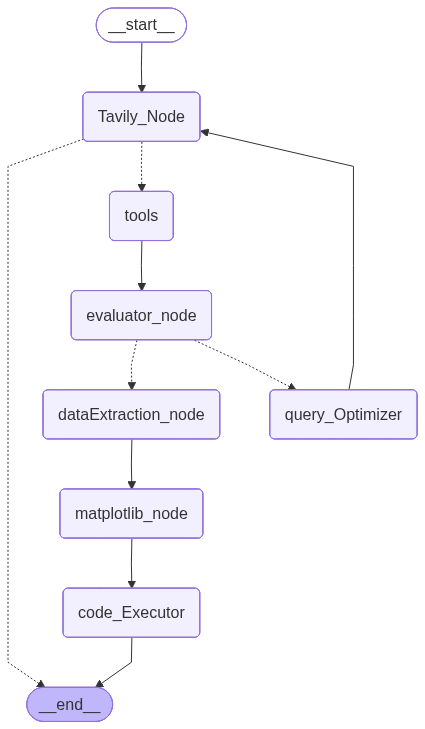

In [210]:
builder = StateGraph(State)
builder.add_node("Tavily_Node" , Tavily_Search_Node)
builder.add_node("evaluator_node" , evaluator_node)
builder.add_node("query_Optimizer" , optimizer_node)
builder.add_node("dataExtraction_node" , data_Extraction_Node)
builder.add_node("matplotlib_node" , matplotlib_node)
builder.add_node("code_Executor" , matplotlib_plot_node)
builder.add_node('tools' , ToolNode(tools))


## Defining the Workflow

builder.add_edge(START , 'Tavily_Node')
builder.add_conditional_edges(
    'Tavily_Node',
    tools_condition
)
builder.add_edge('tools' , "evaluator_node")
builder.add_conditional_edges('evaluator_node' , route_eval , 
                              {
                                  "query_Optimizer": 'query_Optimizer',
                                  "dataExtraction_node" : "dataExtraction_node"
                              })
builder.add_edge('query_Optimizer' , "Tavily_Node")
builder.add_edge('dataExtraction_node' , "matplotlib_node")
builder.add_edge('matplotlib_node' , "code_Executor")
# builder.add_edge('Tavily_Node' , 'evaluator_node')


graph =builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Extraction error: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=SimplifiedData>{"data": "[{\'id\': \'9arsxkgf7\', \'function\': {\'arguments\': \'{"query":"Pakistan birth rate 2021 2022 2023"}\', \'name\': \'tavily_search_results_json\'}, \'type\': \'function\'}]"}</function>'}}


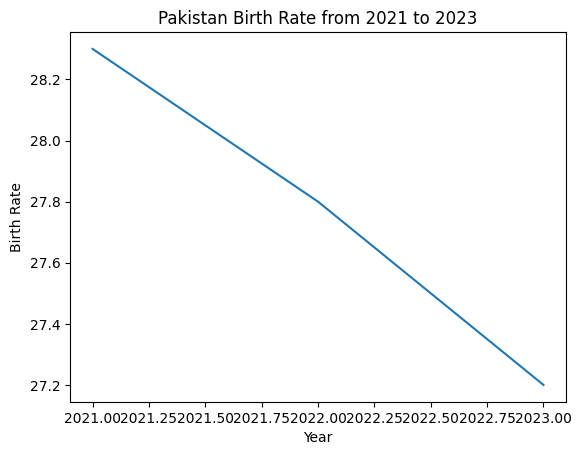

================================ Human Message =================================

what is the Birth rate in Pakistan for past three years
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (9arsxkgf7)
 Call ID: 9arsxkgf7
  Args:
    query: Pakistan birth rate 2021 2022 2023
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Pakistan Birth Rate 1950-2025 - Macrotrends", "url": "https://www.macrotrends.net/global-metrics/countries/PAK/pakistan/birth-rate", "content": "Pakistan birth rate for 2023 was 26.04, a 1.87% decline from 2022. Pakistan birth rate for 2022 was 26.54, a 1.83% decline from 2021. Crude birth rate", "score": 0.9544823}, {"title": "Demographics of Pakistan - Wikipedia", "url": "https://en.wikipedia.org/wiki/Demographics_of_Pakistan", "content": "| Demographics of Pakistan | |\n --- |\n| Population pyramid of Pakistan as of Ju

In [220]:
from pprint import pprint
messages = graph.invoke({"messages" :[HumanMessage(content="what is the Birth rate in Pakistan for past three years")]})
for m in messages['messages']:
    
    m.pretty_print()

In [217]:
messages['messages']

[HumanMessage(content='what is the unemployment rate in Australia for past three years', additional_kwargs={}, response_metadata={}, id='92e04eb2-7573-4336-aff6-d2c59efdbbca'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kw2brh4zn', 'function': {'arguments': '{"query":"Australia unemployment rate past three years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 289, 'total_tokens': 312, 'completion_time': 0.056380836, 'prompt_time': 0.035544439, 'queue_time': 0.00192311, 'total_time': 0.091925275}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--82bd7ec9-517c-44b3-b3d8-f62de44554b0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Australia unemployment rate past three years'}, 'id': 'kw2brh4zn', 'type': 'tool_call'}], usage_metada

In [218]:
messages

{'messages': [HumanMessage(content='what is the unemployment rate in Australia for past three years', additional_kwargs={}, response_metadata={}, id='92e04eb2-7573-4336-aff6-d2c59efdbbca'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kw2brh4zn', 'function': {'arguments': '{"query":"Australia unemployment rate past three years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 289, 'total_tokens': 312, 'completion_time': 0.056380836, 'prompt_time': 0.035544439, 'queue_time': 0.00192311, 'total_time': 0.091925275}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--82bd7ec9-517c-44b3-b3d8-f62de44554b0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Australia unemployment rate past three years'}, 'id': 'kw2brh4zn', 'type': 'tool_call'}]